# Counting and Classification

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import statsmodels.api as smf
import arviz as az
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

### Easy

#### 10E1

If an event has probability 0.35, what are the log-odds of this event?

**Answer:**

$\text{Log-Odds} = \text{log}\frac{p}{1-p} = \text{log}\frac{0.35}{1-0.35} \approx -0.619$

#### 10E2

If an event has log-odds 3.2, what is the probability of this event?

**Answer:**  

$Probability = \frac{\exp(lo)}{1+\exp(lo)} = \frac{\exp(3.2)}{1+\exp(3.2)} \approx 0.96$

#### 10E3

Suppose that a coefficient in a logistic regression has value 1.7. What does this imply about the proportional change in odds of the outcome?

**Answer:**  

A coefficient in a logistic regression with a value of 1.7 would be read as a proportional increase of $\exp(1.7) \approx 5.47$ in the odds of the outcome.

#### 10E4

Why do Poisson regression sometimes require the use of an *offset*? Provide an example.

**Answer:**  

There can be situations where the dataset can provide the average outcome at different intervals. Using the example from the book, we could have a dataset with the average manuscript production for two monasteries. However, one monastery could log the average production per day, while the other could log the average for a week. Implicitly, the parameter $\lambda$ is a expected number of events, $\mu$, per unit time, $\tau$. Hence, we can write $\lambda = \frac{\mu}{\tau}$. $\tau$ then becomes the offset to ensure that expected number of events are calculated at the same time frequency.

### Medium

#### 10M1

As explained in the chapter, binomial data can be organized in aggregated and disaggregated forms, without any impact on inference. But the likelihood of the data does change when the data are converted between the two formats. Can you explain why?

**Answer:**  

Lets us assume we are simulating coin tossing. The disaggregated binomial form simulates one coin toss at a time. Therefore, there is only one way for the combination of coin tosses to happen (1 head or 1 tail). However, when we aggregate coin tosses, then we simulate how many tosses out of `n` came out heads `r`. Since there are many combinations of ways heads or tails could show up (HHHT.., or HTTH..., etc), the likelihood function also has to account for this combination.  

Hence, the likelihood function in the aggregated form has to account for different combinations in which a success or failure can occur. The disaggregated form does not need to account for these combinations. Hence, the likelihoods will be different.

#### 10M2

If a coefficient in a Poisson regression has value 1.7, what does this imply about the change in the outcome?

**Asnwer:**  

A Poisson regression uses a log-link, i.e. $\text{log}(\lambda) = \alpha + \beta X$. Hence a coefficient with a value of 1.7 could be interpreted as the rate of expected events. (log($\lambda$)) increases by 1.7 times for every unit increase in the input. Another interpretation would be that the expected number of events increases by $\exp(1.7) \approx 5.47$ for every unit increase in X.

#### 10M3

Explain why the logit link is appropriate for a binomial generalized linear regression.

**Answer:**  

The logit-link models the logit(p) as a linear combination of observed features. Using a logit link is useful as it ensures that predicted values for p cannot go above 1 or below 0 - an important requirement for a probability!

#### 10M4

Explain why the log link is appropriate for a Poisson generalized linear regression.

**Answer:**  

A Poisson distribution can be written as
$P(\lambda, k) = \frac{\lambda^k\exp(-\lambda)}{k!}$. As can be seen, in order to get a probability value between 0 and 1, we require that $\lambda$ is not negative. Else, the numerator can become negative (if k is odd) or more than 1 (if k is even). In order to ensure this does not happen, we require that $\lambda$ is always positive (or zero). This can be done by modelling taking a log-link for a Poisson generalized linear regression.

#### 10M5

What would it imply to use a logit link for the mean of a Poisson generalized linear model? Can you think of a real research problem for which this would make sense?

**Answer:**  

Using a logit link for a Poisson generalized linear model would imply that $\lambda$ would always be between 0 and 1. This would in turn mean that the numerator in the Poisson distribution will be very small, and the probability will be miniscule too.

Not completely sure, but we may want to use a logit-link for a Poisson regression if the expected number of events is a fraction. For example, the rate of death (per year) can be between 0 and 1 and this value can be used to predict the probability of Death.

#### 10M6

State the constraints for which the binomial and Poisson distributions have maximum entropy. Are the constraints different at all for binomial and Poisson? Why or why not?

**Answer:**  

Binomial distributions have maximum entropy when only 2 un-ordered outcomes are possible and the process generating the outcomes is invariant in time.
Poisson distributions is a special case of a binomial distribution. Hence, it has the same constraints as a binomial distribution. 

### Hard

#### 10H1

Use `map` to construct a quadratic approximate posterior distribution for the chimpanzee model that includes a unique intercept for each actor, `m10.4` (page 299). Compare the quadratic approximation to the posterior distribution produced instead from MCMC. Can you explain both the differences and the similarities between the approximate and the MCMC distributions?

In [99]:
d = pd.read_csv("../../data/chimpanzees.csv", sep=";")

# Change actor to be zero-indexed
d.actor -= 1

# Quadratic Approximation
with pm.Model() as m10_h1a:
    a = pm.Normal("a", mu=0, sd=10, shape=d.actor.nunique())
    bp = pm.Normal("bp", mu=0, sd=10)
    bpC = pm.Normal("bpC", mu=0, sd=10)
    p = pm.Deterministic('p', pm.math.invlogit(a[d.actor] + (bp + bpC * d.condition) * d.prosoc_left))
    pulled_left = pm.Binomial("pulled_left", n=1, p=p, observed=d.pulled_left)
    mean_q = pm.find_MAP()
    std_a = ((1/pm.find_hessian(mean_q, vars=[a]))**0.5)
    std_bp = ((1/pm.find_hessian(mean_q, vars=[bp]))**0.5)
    std_bpC = ((1/pm.find_hessian(mean_q, vars=[bpC]))**0.5)


logp = -285.87, ||grad|| = 0.38205: 100%|██████████| 20/20 [00:00<00:00, 1628.79it/s]  


Text(0, 0.5, 'Density')

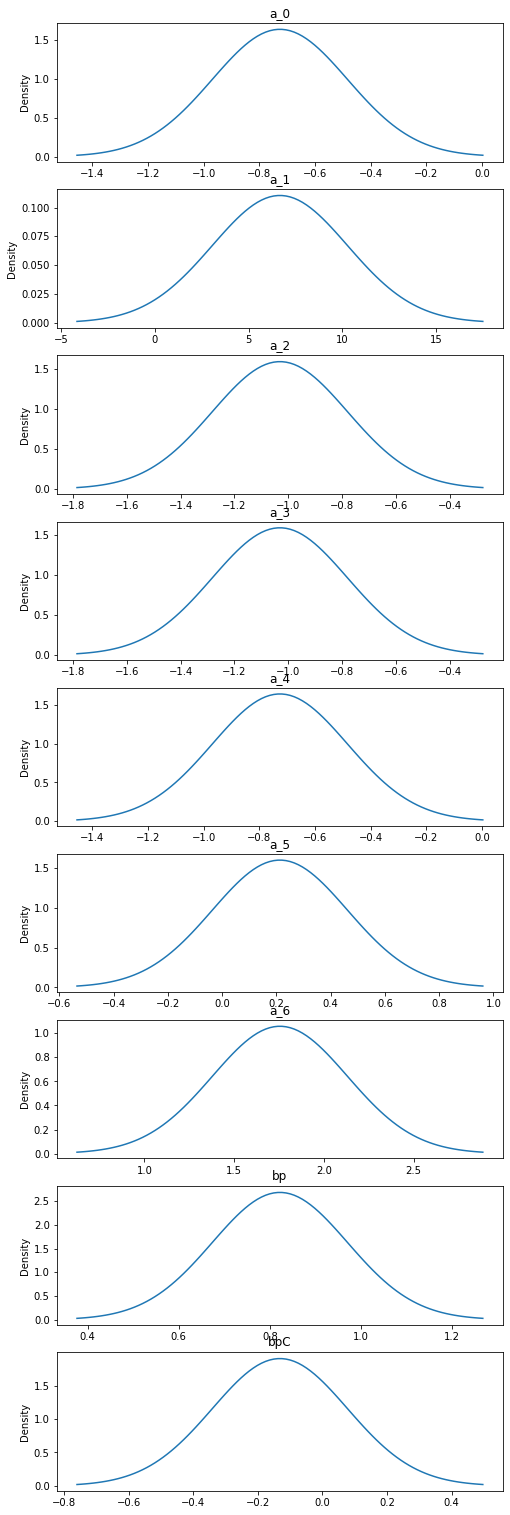

In [112]:
fig, axes = plt.subplots(9,1, figsize=(8,27))
axs = axes.flatten()

for i in range(d.actor.nunique()):
    mean = mean_q['a'][i]
    std = std_a[i][i]
    x = np.linspace(mean - 3 * std, mean + 3 * std, 100)
    axs[i].plot(x, stats.norm.pdf(x, mean, std))
    axs[i].set_title(f"a_{i}")
    axs[i].set_ylabel("Density")

mean = mean_q['bp']
std = std_bp[0]
x = np.linspace(mean - 3 * std, mean + 3 * std, 100)
axs[-2].plot(x, stats.norm.pdf(x, mean, std))
axs[-2].set_title("bp")
axs[-2].set_ylabel("Density")

mean = mean_q['bpC']
std = std_bpC[0]
x = np.linspace(mean - 3 * std, mean + 3 * std, 100)
axs[-1].plot(x, stats.norm.pdf(x, mean, std))
axs[-1].set_title("bpC")
axs[-1].set_ylabel("Density");

In [51]:
with pm.Model() as m10_h1b:
    a = pm.Normal("a", mu=0, sd=10, shape=d.actor.nunique())
    bp = pm.Normal("bp", mu=0, sd=10)
    bpC = pm.Normal("bpC", mu=0, sd=10)
    p = pm.Deterministic('p', pm.math.invlogit(a[d.actor] + (bp + bpC * d.condition) * d.prosoc_left))
    pulled_left = pm.Binomial("pulled_left", n=1, p=p, observed=d.pulled_left)
    trace_m10_h1b = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, a]
Sampling 2 chains, 11 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 382.54draws/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


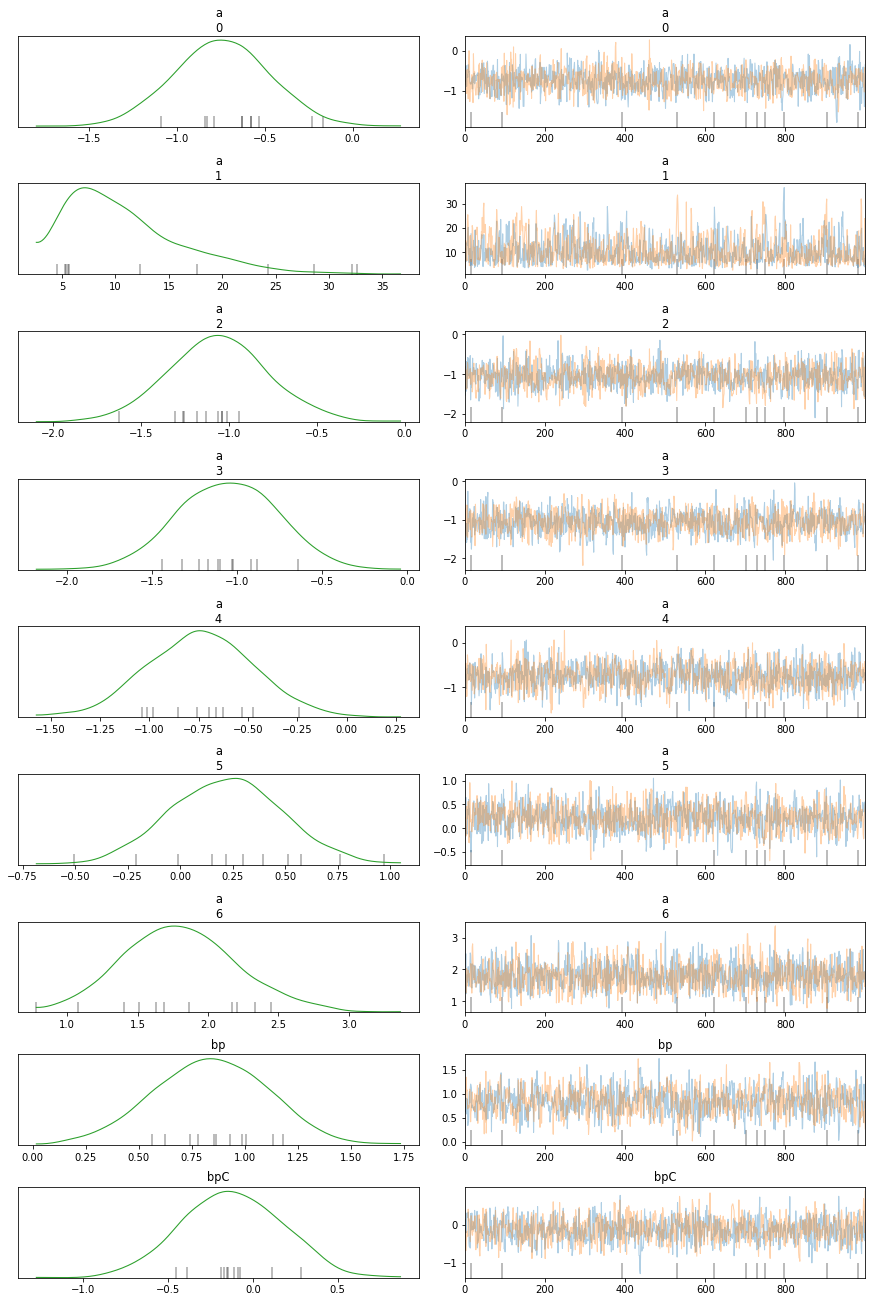

In [93]:
az.plot_trace(trace_m10_h1b, var_names=["~p"], combined=True);

#### 10H2

Use WAIC to compare the chimpanzee model that includes a unique intercept for each actor, `m10.4` (page 299), to the simpler models fit in the same section.

In [114]:
with pm.Model() as m10_h2a:
    a = pm.Normal("a", mu=0, sd=10)
    bp = pm.Normal("bp", mu=0, sd=10)
    p = pm.math.invlogit(a + bp * d.prosoc_left)
    pulled_left = pm.Binomial("pulled_left", n=1, p=p, observed=d.pulled_left)
    trace_m10_h2a = pm.sample(1000, tune=1000)
    
with pm.Model() as m10_h2b:
    a = pm.Normal("a", mu=0, sd=10)
    bp = pm.Normal("bp", mu=0, sd=10)
    bpC = pm.Normal("bpC", mu=0, sd=10)
    p = pm.math.invlogit(a + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial("pulled_left", n=1, p=p, observed=d.pulled_left)
    trace_m10_h2b = pm.sample(1000, tune=1000)

with pm.Model() as m10_h2c:
    a = pm.Normal("a", mu=0, sd=10, shape=d.actor.nunique())
    bp = pm.Normal("bp", mu=0, sd=10)
    bpC = pm.Normal("bpC", mu=0, sd=10)
    p = pm.Deterministic('p', pm.math.invlogit(a[d.actor] + (bp + bpC * d.condition) * d.prosoc_left))
    pulled_left = pm.Binomial("pulled_left", n=1, p=p, observed=d.pulled_left)
    trace_m10_h2c = pm.sample(1000, tune=1000)
    
compare_df = az.compare({f"m10_h2{i}": eval(f"trace_m10_h2{i}") for i in list("abc")})
compare_df

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bp, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 865.42draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 674.83draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, a]
Sampling 2 chains, 13 divergences: 100%|██████████| 4000/4000 [00:15<00:00, 257.24draws/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m10_h2c,0,530.296,8.55455,0,1,9.63287,0,False,deviance
m10_h2a,1,680.705,2.10185,150.41,8.23428e-22,20.8713,19.2269,False,deviance
m10_h2b,2,682.303,2.9804,152.008,4.95134e-22,9.66269,19.1621,False,deviance


#### 10H3

The data contained in `library(mass);data(eagles)` are records of salmon pirating attempts by Bald Eagles in Washington State. See `?eagles` for details. While one eagle feeds, sometimes another will swoop in and try to steal the salmon from it. Call the feeding eagle the "victim" and the thief the "pirate". Use the available data to build a binomial GLM of successful pirating attempts.

In [124]:
d = pd.read_csv("../../data/eagles.csv")
d["Ac"] = d.A.astype('category').cat.codes
d["Pc"] = d.P.astype('category').cat.codes
d["Vc"] = d.V.astype('category').cat.codes
d

,y,n,P,A,V,Ac,Pc,Vc
0,17,24,L,A,L,0,0,0
1,29,29,L,A,S,0,0,1
2,17,27,L,I,L,1,0,0
3,20,20,L,I,S,1,0,1
4,1,12,S,A,L,0,1,0
5,15,16,S,A,S,0,1,1
6,0,28,S,I,L,1,1,0
7,1,4,S,I,S,1,1,1


1. Consider the following model:

$$
\begin{align}
y_i &\sim \text{Binomial($n_i, p_i$)} \\
\text{log}\frac{p_i}{1-p_i} &= \alpha + \beta_PP_i + \beta_VV_i + \beta_AA_i \\
\alpha &\sim \text{Normal(0, 10)} \\
\beta_P &\sim \text{Normal(0, 5)} \\
\beta_V &\sim \text{Normal(0, 5)} \\
\beta_A &\sim \text{Normal(0, 5)} \\
\end{align}
$$  

where *y* is the number of successful attempts, *n* is the total number of attempts, *P* is a dummy variable indicating whether or not the pirate had a large body size, *V* is a dummy variable indicating whether or not the victim had a large body size, and finally *A* is a dummy variable indicating whether or not the pirate was an adult. Fit the model above to the `eagles` data, using both `map` and `map2stan`. Is the quadratic approximation okay?

In [138]:
# Quadratic Approach
with pm.Model() as m10_h3a:
    a = pm.Normal("a", mu=0, sd=10)
    b = pm.Normal("bp", mu=0, sd=5, shape=3)
    p = pm.Deterministic("p", pm.math.invlogit(a + b[0] * d.Pc + b[1] * d.Vc + b[2] * d.Ac))
    y = pm.Binomial("y", n=d.n, p=p, observed=d.y)
    mean_q = pm.find_MAP()
    std_a = ((1/pm.find_hessian(mean_q, vars=[a, b]))**0.5)

logp = -21.524, ||grad|| = 0.0083326: 100%|██████████| 14/14 [00:00<00:00, 1530.53it/s]  


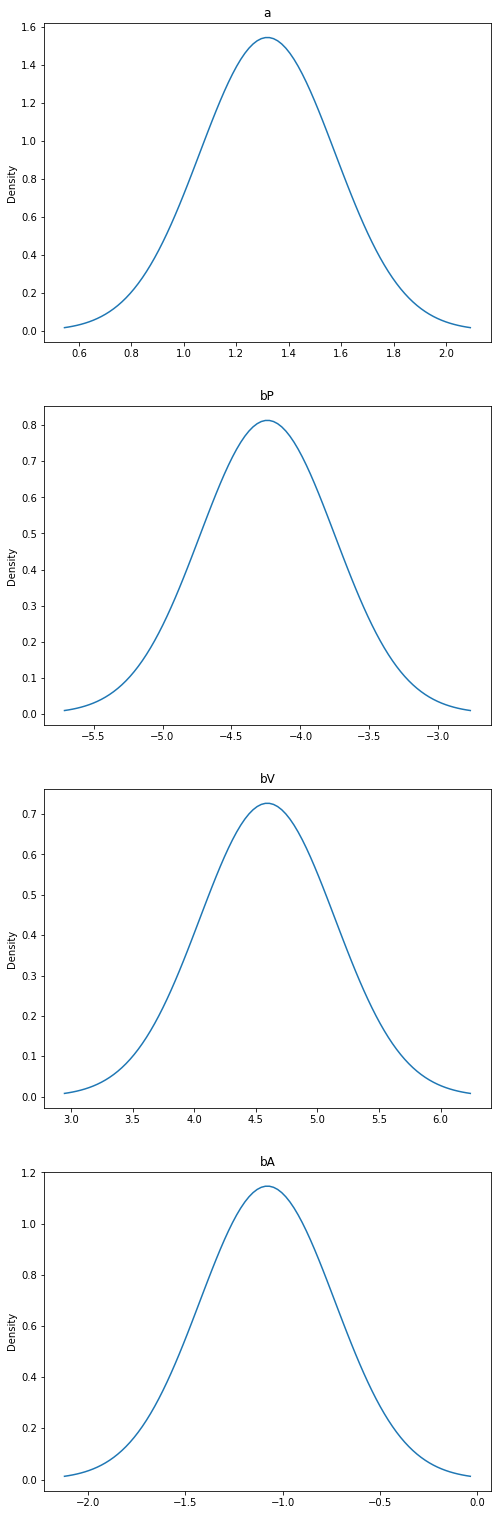

In [139]:
fig, axes = plt.subplots(4,1, figsize=(8,27))

for i, (v, ax) in enumerate(zip(["a", "bP", "bV", "bA"], axes.flatten())):
    mean = mean_q["bp"][i-1] if i else mean_q["a"]
    std = std_a[i][i]
    x = np.linspace(mean - 3 * std, mean + 3 * std, 100)
    ax.plot(x, stats.norm.pdf(x, mean, std))
    ax.set_title(v)
    ax.set_ylabel("Density")
plt.show();

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bp, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 858.67draws/s]


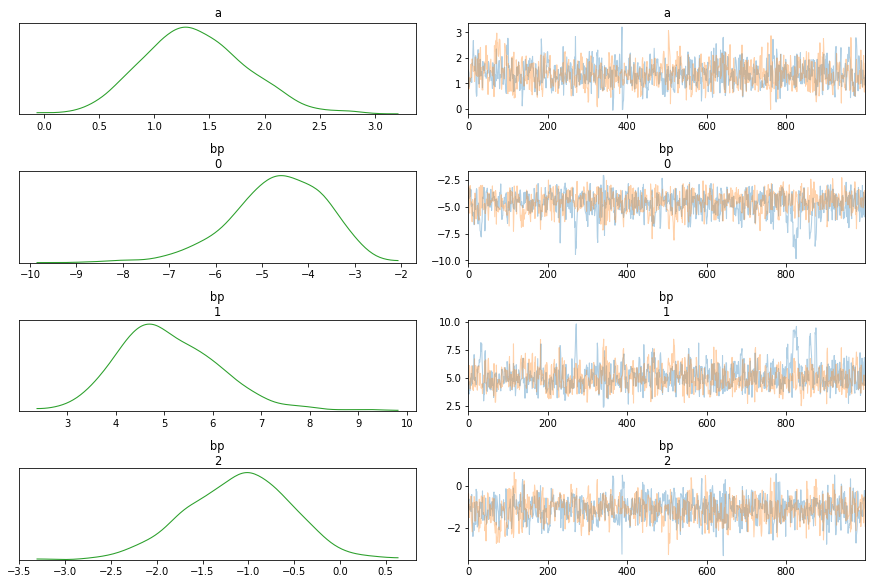

In [140]:
# map2stan equivalent
with pm.Model() as m10_h3b:
    a = pm.Normal("a", mu=0, sd=10)
    b = pm.Normal("bp", mu=0, sd=5, shape=3)
    p = pm.Deterministic("p", pm.math.invlogit(a + b[0] * d.Pc + b[1] * d.Vc + b[2] * d.Ac))
    y = pm.Binomial("y", n=d.n, p=p, observed=d.y)
    trace_m10_h3b = pm.sample(1000, tune=1000)
az.plot_trace(trace_m10_h3b, var_names=["~p"], combined=True);

2. Now interpret the estimates. If the quadratic approximation turned out okay, then it’s okay to use the `map` estimates. Otherwise stick to `map2stan` estimates. Then plot the posterior predictions. Compute and display both (1) the predicted **probability** of success and its 89% interval for each row (i) in the data, as well as (2) the predicted success **count** and its 89% interval. What different information does each type of posterior prediction provide?

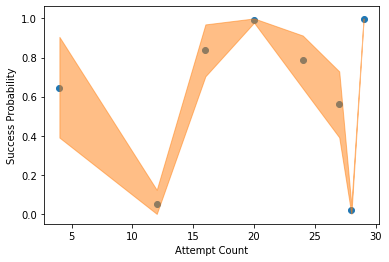

In [206]:
# Predicted Probability of Success
plt.scatter(d.n, trace_m10_h3b["p"].mean(0))
az.plot_hpd(d.n, trace_m10_h3b["p"], smooth=False, credible_interval=0.89)
plt.xlabel("Attempt Count")
plt.ylabel("Success Probability");

100%|██████████| 1000/1000 [00:00<00:00, 1187.04it/s]


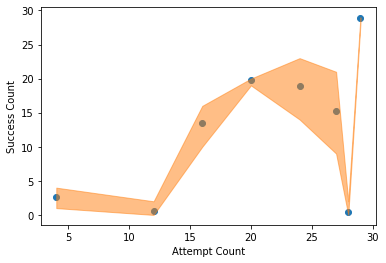

In [207]:
# Success count
post = pm.sample_posterior_predictive(trace_m10_h3b, 1000, m10_h3b)

plt.scatter(d.n, post["y"].mean(0))
az.plot_hpd(d.n, post["y"], smooth=False, credible_interval=0.89)
plt.xlabel("Attempt Count")
plt.ylabel("Success Count");

3. Now try to improve the model. Consider an interaction between the pirate’s size and age (immature or adult). Compare this model to the previous one, using WAIC. Interpret.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bp, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:06<00:00, 651.69draws/s]


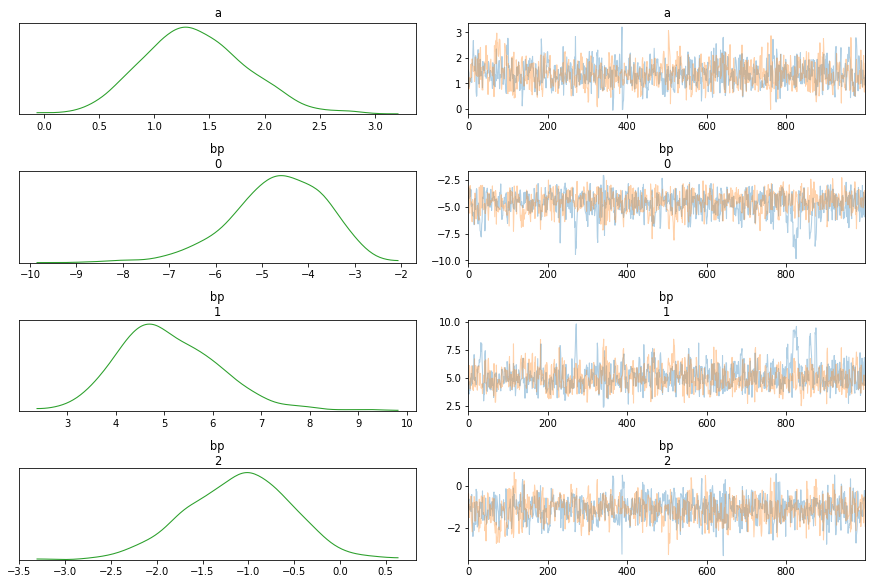

In [208]:
with pm.Model() as m10_h3c:
    a = pm.Normal("a", mu=0, sd=10)
    b = pm.Normal("bp", mu=0, sd=5, shape=4)
    p = pm.Deterministic("p", pm.math.invlogit(a + b[0] * d.Pc + b[1] * d.Vc + b[2] * d.Ac + b[3] * d.Pc * d.Ac))
    y = pm.Binomial("y", n=d.n, p=p, observed=d.y)
    trace_m10_h3c = pm.sample(1000, tune=1000)
az.plot_trace(trace_m10_h3b, var_names=["~p"], combined=True);

In [209]:
compare_df = az.compare({f"m10_h3{i}": eval(f"trace_m10_h3{i}") for i in list("bc")})
compare_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m10_h3c,0,20.4326,1.96853,0,0.984559,7.18759,0,True,deviance
m10_h3b,1,30.6909,5.19114,10.2583,0.0154409,5.21049,3.19579,True,deviance


#### 10H4

The data contained in `data(salamanders)` are counts of salamanders (*Plethodon elongatus*) from 47 different 49-m$^2$ plots in northern California. The column `SALAMAN` is the count in each plot, and the columns `PCTCOVER` and `FORESTAGE` are percent of ground cover and age of trees in the plot, respectively. You will model `SALAMAN` as a Poisson variable.

In [237]:
d = pd.read_csv("../../data/salamanders.csv", sep=";")
d.PCTCOVER /= 100
d["FORESTAGE_c"] = d.FORESTAGE / d.FORESTAGE.max()
d.head()

,SITE,SALAMAN,PCTCOVER,FORESTAGE,FORESTAGE_c
0,1,13,0.85,316,0.468148
1,2,11,0.86,88,0.130370
2,3,11,0.90,548,0.811852
3,4,9,0.88,64,0.094815
4,5,8,0.89,43,0.063704


1. Model the relationship between density and percent cover, using a log-link (same as the example in the book and lecture). Use weakly informative priors of your choosing. Check the quadratic approximation again, by comparing map to `map2stan`. Then plot the expected counts and their 89% interval against percent cover. In which ways does the model do a good job? In which ways does it do a bad job?

In [251]:
# Skipping quadratic approximation

with pm.Model() as m10_h4a:
    a = pm.Normal("a", mu=0, sd=2)
    b = pm.Normal("b", mu=0, sd=2)
    lam = pm.Deterministic("lambda", pm.math.exp(a + b * d.PCTCOVER))
    salaman = pm.Poisson("salamander", mu=lam, observed=d.SALAMAN)
    trace_m10_h4a = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 968.37draws/s] 
The acceptance probability does not match the target. It is 0.8817141731414553, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


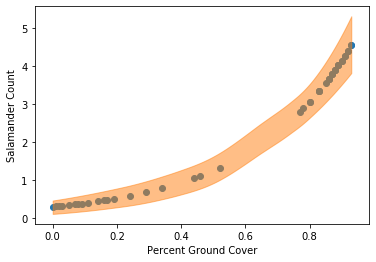

In [252]:
# Expected Success count
plt.scatter(d.PCTCOVER, trace_m10_h4a["lambda"].mean(0))
az.plot_hpd(d.PCTCOVER, trace_m10_h4a["lambda"], credible_interval=0.89)
plt.xlabel("Percent Ground Cover")
plt.ylabel("Salamander Count");

2. Can you improve the model by using the other predictor, `FORESTAGE`? Try any models you think useful. Can you explain why `FORESTAGE` helps or does not help with prediction?

In [247]:
with pm.Model() as m10_h4b:
    a = pm.Normal("a", mu=0, sd=2)
    b = pm.Normal("b", mu=0, sd=2, shape=3)
    lam = pm.Deterministic("lambda", pm.math.exp(a + b[0] * d.PCTCOVER + b[1] * d.FORESTAGE_c + b[2] * d.PCTCOVER * d.FORESTAGE_c))
    salaman = pm.Poisson("salamander", mu=lam, observed=d.SALAMAN)
    trace_m10_h4b = pm.sample(1000, tune=1000)
    post = pm.sample_posterior_predictive(trace_m10_h4b, 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
100%|██████████| 1000/1000 [00:01<00:00, 887.12it/s]


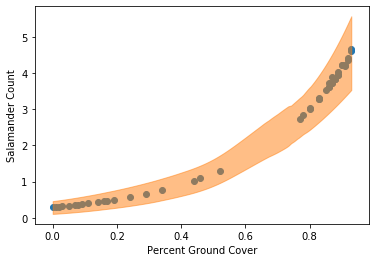

In [250]:
# Expected Success count
plt.scatter(d.PCTCOVER, trace_m10_h4b["lambda"].mean(0))
az.plot_hpd(d.PCTCOVER, trace_m10_h4b["lambda"], credible_interval=0.89)
plt.xlabel("Percent Ground Cover")
plt.ylabel("Salamander Count");

In [253]:
az.compare({
    "m10_h4a": trace_m10_h4a,
    "m10_h4b": trace_m10_h4b
})

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m10_h4a,0,213.045,4.39792,0,0.893048,25.9178,0,True,deviance
m10_h4b,1,217.712,7.57512,4.66708,0.106952,26.893,1.53391,True,deviance
